In [1]:

"""
通过langgraph来创建多智能体，实现对输入新闻文章的改进。

"""

import os, json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder


In [2]:
from pydantic import BaseModel, Field

model = "Qwen2.5-7B-Instruct-AWQ"
# model = "internlm2_5-7b-chat"

llm = ChatOpenAI(api_key="EMPTY", base_url="http://localhost:8000/v1", model=model,
                temperature=0.7,
                max_tokens=None)


# 评价Agent：指出文章的不足之处
class CriticOutput(BaseModel):
    critic_output: str = Field(description="指出新闻或文章的不足之处，要求尽可能简洁明了。")


critic_llm_with_structured_output = llm.with_structured_output(CriticOutput)

# 润色Agent： 根据news和不足之处进行文章润色。
class CorrectNews(BaseModel):
    correct_news: str = Field(description="根据输入的新闻或文章的不足之处对输入进行润色，尽可能简洁通俗易懂。")

correct_llm_with_structured_output = llm.with_structured_output(CorrectNews)

# 评估润色后的文章Agent

class EvalScore(BaseModel):
    #Field(description="对输入的文章从结构、语法、写作完整性进行综合评估，得分范围-10，分值越大，文章越好")
    structure_score: int = Field(description="对输入的文章从结构方面进行综合评估，得分范围1-10，分值越大，文章越好")
    grammar_score: int = Field(description="对输入的文章从语法方面进行综合评估，得分范围1-10，分值越大，文章越好")
    writing_integrity_score: int = Field(description="对输入的文章从写作完整性方面进行综合评估，得分范围1-10，分值越大，文章越好")

eval_llm_with_structured_output = llm.with_structured_output(EvalScore)


In [3]:

from typing import Annotated, TypedDict
# from typing_extensions import TypedDict

from langgraph.graph import START, END, StateGraph


class State(TypedDict):
    origin_news: Annotated[str, "这是最原始的文章内容"]  # 第一次输入的文章
    inadequacy: Annotated[str, "这是文章的不足之处"]  # 不足之处
    corrected_news: Annotated[str, "这是根据不足之处改进后的文章内容"] # 润色之后的文章
    score: Annotated[float,"文章评估得分"]



# print(State()["corrected_new"])

def critic_agent(state: State) -> State:
    print("--------------critic_agent---------------------")
    print(state)
    flag = False
    if "corrected_news" not in state:
    # if state["corrected_news"]:  # 若为空，则是第一次调用该Agent。
        state["corrected_news"] = state["origin_news"]
        flag= True
    print(state)
    template = """ 根据下面的文章，指出其不足之处，不足之处从下面的角度进行简短的回答，每个方面的不足描述要求简短、通俗易懂，20字左右：
    1. 文章的完整性。
    2. 文章的辞藻是否华丽
    3. 文章是否能够吸引读者。

    文章内容：
    {news}
    不足之处为(中文回答)：
    """
    
    prompt = PromptTemplate.from_template(template=template)
    # chain = prompt | critic_llm_with_structured_output
    chain = prompt | llm
    response = chain.invoke({"news": state["corrected_news"]})
    inadequacy = response.content
    if not flag:
        return {"inadequacy": inadequacy}
    else:
        return {"inadequacy": inadequacy, "corrected_news": state["corrected_news"]}


def correct_agent(state: State)-> State:
    print("--------------correct_agent---------------------")
    print(state)

    template = """你是一个资深的文章编辑，善于根据不足之处完善文章，请根据下面的文章以及对应的不足之处进行完善文章内容。
    文章：
    {news}
    不足之处：
    {inadequacy}
    完善后的文章内容（中文回答）：
    """

    prompt = PromptTemplate.from_template(template=template)
    # chain = prompt | correct_llm_with_structured_output
    chain = prompt | llm

    response = chain.invoke({"news": state["corrected_news"], "inadequacy": state["inadequacy"]})

    # corrected_news = response.correct_news
    corrected_news = response.content
    return {"corrected_news": corrected_news}


def eval_agent(state: State):
    print("--------------eval_agent---------------------")
    print(state)
    if "corrected_news" not in state:
    # if not state["corrected_news"]:  # 首先进行评估
        state["corrected_news"] = state["origin_news"]

    news = state["corrected_news"]

    template = """给定下面的文章，对输入的文章从结构、语法、写作完整性进行综合评估，得分范围1-10，分值越大，文章越好。
    文章如下：
    {news}
    """

    prompt = PromptTemplate.from_template(template)

    chain = prompt | eval_llm_with_structured_output
    response = chain.invoke({"news": state["corrected_news"]})
    structure_score = response.structure_score
    grammar_score = response.grammar_score
    writing_integrity_score = response.writing_integrity_score

    mean_score = (structure_score + grammar_score + writing_integrity_score) * 1.0 / 3
    print("得分列表：", [structure_score, grammar_score, writing_integrity_score])
    return {"score": mean_score}

def router_query(state: State):
    
    print("--------------router_query---------------------")
    print(state)
    if state["score"] > 8.0:  # 结束
        return END
    else:
        return "critic_agent"
    


In [4]:

# 创建multi-agent的flow

builder = StateGraph(State)

builder.add_node("critic_agent",critic_agent)
builder.add_node("correct_agent", correct_agent)
builder.add_node("eval_agent", eval_agent)

builder.add_edge("critic_agent", "correct_agent")
builder.add_edge("correct_agent", "eval_agent")

builder.add_conditional_edges("eval_agent", router_query, {END: END, "critic_agent": "critic_agent"})

builder.set_entry_point("eval_agent")

app = builder.compile()


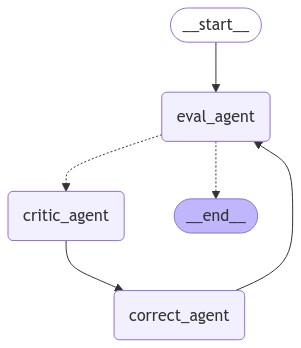

In [5]:
# 打印工作流workflow

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [6]:

"""
测试一个实例
"""

news = "近年来，人工智能（AI）技术的迅猛发展正引发全球范围内的关注。从自动驾驶汽车到智能语音助手，AI已经逐渐融入我们的日常生活。科技公司纷纷投入巨资，推动这一领域的创新与应用。\n虽然AI技术广泛应用于多个行业，如医疗、金融和制造业，但它仍面临不少挑战。例如，数据隐私、伦理问题以及自动化带来的就业替代风险都成为讨论的热点。同时，AI的未来发展潜力巨大，许多专家认为，随着技术的成熟，AI将进一步改善生产效率、提升生活质量。\n随着社会对智能技术的需求不断增长，AI的未来前景令人期待。然而，如何在发展中应对挑战，将成为下一步的重要议题。"
news = """
近几年，人工智能（AI）技术发展的速度很快，很驶、智能家居和医疗健康等方面，人工智能术也带来了一些问题。

一些专家指出，AI的应用可能会导致很多人失业，尤其是类完成大量的工作。同时，数据安全问题也是一个大问题，很多用户担心他们的个人信息会被泄露。此外，虽然AI技术很强大，但目前仍然有不少局限性，无法完全取代人类的智慧和创作能力。

总的来说，人工智能的发张给社会带来了许多便利，但也面临着不少挑站。在未来，如何平衡AI带来的利与弊，成为了大家需要深思的一个问题。
"""
inputs = {"origin_news": news}

new_news = app.invoke(inputs)

print(new_news)

--------------eval_agent---------------------
{'origin_news': '\n近几年，人工智能（AI）技术发展的速度很快，很驶、智能家居和医疗健康等方面，人工智能术也带来了一些问题。\n\n一些专家指出，AI的应用可能会导致很多人失业，尤其是类完成大量的工作。同时，数据安全问题也是一个大问题，很多用户担心他们的个人信息会被泄露。此外，虽然AI技术很强大，但目前仍然有不少局限性，无法完全取代人类的智慧和创作能力。\n\n总的来说，人工智能的发张给社会带来了许多便利，但也面临着不少挑站。在未来，如何平衡AI带来的利与弊，成为了大家需要深思的一个问题。\n'}
得分列表： [8, 8, 7]
--------------router_query---------------------
{'score': 7.666666666666667, 'origin_news': '\n近几年，人工智能（AI）技术发展的速度很快，很驶、智能家居和医疗健康等方面，人工智能术也带来了一些问题。\n\n一些专家指出，AI的应用可能会导致很多人失业，尤其是类完成大量的工作。同时，数据安全问题也是一个大问题，很多用户担心他们的个人信息会被泄露。此外，虽然AI技术很强大，但目前仍然有不少局限性，无法完全取代人类的智慧和创作能力。\n\n总的来说，人工智能的发张给社会带来了许多便利，但也面临着不少挑站。在未来，如何平衡AI带来的利与弊，成为了大家需要深思的一个问题。\n'}
--------------critic_agent---------------------
{'origin_news': '\n近几年，人工智能（AI）技术发展的速度很快，很驶、智能家居和医疗健康等方面，人工智能术也带来了一些问题。\n\n一些专家指出，AI的应用可能会导致很多人失业，尤其是类完成大量的工作。同时，数据安全问题也是一个大问题，很多用户担心他们的个人信息会被泄露。此外，虽然AI技术很强大，但目前仍然有不少局限性，无法完全取代人类的智慧和创作能力。\n\n总的来说，人工智能的发张给社会带来了许多便利，但也面临着不少挑站。在未来，如何平衡AI带来的利与弊，成为了大家需要深思的一个问题。\n', 'score': 7.666666666666667}
{'o

In [7]:


# 调试后发现是生成文章不足之处的Agent效果较差

tmp_template = """ 根据下面的文章，指出其不足之处，不足之处从下面的角度指出,每个方面的不足描述要求简短、通俗易懂，20字左右：
    1. 文章的完整性。
    2. 文章的辞藻是否华丽
    3. 文章是否能够吸引读者。

    文章内容：
    {news}
    
    """


tmp_prompt = PromptTemplate.from_template(tmp_template)
# tmp_chain = tmp_prompt | critic_llm_with_structured_output

tmp_chain = tmp_prompt | llm

print(tmp_chain.invoke({"news":news}))



content='文章的完整性方面：文章内容较为单一，仅讲述了AI带来的问题，而未提及AI带来的积极影响，如提高效率、促进创新等。\n\n文章的辞藻是否华丽：文章语言较为简单，缺乏修辞手法和生动的描述，显得较为平淡。\n\n文章是否能够吸引读者：文章主要聚焦于AI的负面影响，缺乏正面积极的视角，可能引起读者的悲观情绪，缺乏激发兴趣的元素。' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 216, 'total_tokens': 307, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen2.5-7B-Instruct-AWQ', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-f68fbd7a-7dda-45f3-9d2f-953ec9fa6b26-0' usage_metadata={'input_tokens': 216, 'output_tokens': 91, 'total_tokens': 307, 'input_token_details': {}, 'output_token_details': {}}
